Paper: https://arxiv.org/abs/1505.04597

In [1]:
!pip -q install torchinfo
!pip -q install torchview

In [2]:
import torch
from torch import nn
import torchvision.transforms.functional as TF

from torchinfo import summary
from torchview import draw_graph

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision

In [3]:
import os
import glob

from sklearn.model_selection import train_test_split

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

# Downloa Dataset from Kaggel

In [ ]:
# 1. Read the kaggle API token to interact with your kaggle account
from google.colab import files
files.upload()

#2. Series of commands to set-up for download
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

#3. giving rw access (if 401-nathorized)
!chmod 600 ~/.kaggle/kaggle.json

#4. Sanity check if able to access kaggle
# !kaggle datasets list

#5. Download data command
!kaggle datasets download -d "nikhilroxtomar/person-segmentation" -p /content/dataset
# for example: !kaggle datasets download -d thedevastator/hubmap-2022-512x512 -p < /content/drive/MyDrive/Task2_hubmap

In [5]:
#6. unzip
!unzip -q "/content/dataset/person-segmentation.zip" -d "/content/person-segmentation"

In [ ]:
# !rm -r "/content/person-segmentation"

# Helper Function

In [6]:
def test_model(model, x):
  preds = model(x)
  print(preds.shape)

  print("Input :", x.shape)
  print("Output :", preds.shape)

  # Modified assertion to check batch size and spatial dimensions, allowing channel dimension to differ
  assert preds.shape[0] == x.shape[0] and preds.shape[2:] == x.shape[2:]

In [7]:
def find_all_image_paths(directory_path):
    """
    Finds all image files in the given directory and its subdirectories.

    Supported formats:
    .png, .jpg, .jpeg, .bmp, .tiff, .tif, .webp, .gif

    Args:
        directory_path (str): The starting directory path.

    Returns:
        list: A list of paths to all image files found.
    """

    image_extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp',
                        '*.tiff', '*.tif', '*.webp', '*.gif')

    image_paths = []

    for ext in image_extensions:
        search_pattern = os.path.join(directory_path, '**', ext)
        image_paths.extend(glob.glob(search_pattern, recursive=True))
        search_pattern_upper = os.path.join(directory_path, '**', ext.upper())
        image_paths.extend(glob.glob(search_pattern_upper, recursive=True))

    return image_paths

In [8]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("💾 Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("🚀 Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [9]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.float().unsqueeze(1).to(device)
            y = (y > 0.5).float()

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum().item()
            num_pixels += preds.numel()

            dice = (2 * (preds * y).sum(dim=(2,3)) + 1e-8) / (
                preds.sum(dim=(2,3)) + y.sum(dim=(2,3)) + 1e-8
            )
            dice_score += dice.mean().item()

    print(f"Accuracy: {num_correct / num_pixels * 100:.2f}%")
    print(f"Dice score: {(dice_score / len(loader)):.4f}")

    model.train()

In [10]:
def val_loss(loader, model, loss_fn, device="cuda"):
    model.eval()
    losses = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.float().unsqueeze(1).to(device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss.item())

    model.train()
    return sum(losses) / len(losses)

In [11]:
# def save_predictions_as_imgs(
#     loader, model, folder="saved_images/", device="cuda"
# ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         torchvision.utils.save_image(
#             preds, f"{folder}/pred_{idx}.png"
#         )
#         torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

#     model.train()

In [12]:
def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    for idx, (x, y) in enumerate(loader):
      if idx == 0:
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

      else:
        break

    model.train()

In [13]:
# # Source - https://stackoverflow.com/a/71999355
# # Posted by KarelZe, modified by community. See post 'Timeline' for change history
# # Retrieved 2026-01-27, License - CC BY-SA 4.0

# class EarlyStopping:
#     def __init__(self, tolerance=5, min_delta=0):

#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False

#     def __call__(self, train_loss, validation_loss):
#         if (validation_loss - train_loss) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:
#                 self.early_stop = True

import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


# U-NET Model

In [ ]:
# Reverse the list
# li = [1, 2, 3, 4]
# print(li[::-1])

In [ ]:
# li = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# for i in range(0, len(li), 2):
#   print(i, i//2)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # 1st Conv layer
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # bias is false becouse we use batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # 2nd Conv layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [ ]:
model = UNet(in_channels=3, out_channels=1)

summary(model, input_size=(1, 3, 256, 256))

# model_graph = draw_graph(model, input_size=(1, 3, 256, 256), expand_nested=True)
# model_graph.visual_graph

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 256, 256]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [1, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [1, 64, 256, 256]         38,848
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [1, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [1, 128, 128, 128]        221,696
├─MaxPool2d: 1-4                         [1, 128, 64, 64]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [1, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [1, 256, 64, 64]          885,760
├─MaxPool2d: 1-6                         [1,

In [ ]:
x = torch.randn((4, 3, 256, 256))
model = UNet(in_channels=3, out_channels=1) # Modified in_channels to 3
test_model(model, x)

torch.Size([4, 1, 256, 256])
Input : torch.Size([4, 3, 256, 256])
Output : torch.Size([4, 1, 256, 256])


# ResUNET Model

In [14]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights

In [15]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()

        # Upsampling
        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )

        # Convolutions after concatenation
        self.conv1 = nn.Conv2d(
            out_channels + skip_channels, out_channels, kernel_size=3, padding=1
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.up(x)                # upsample
        x = torch.cat([x, skip], dim=1)  # skip connection

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


In [16]:
class ResNetUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, encoder_name="resnet34", pretrained=True):
        super(ResNetUNet, self).__init__()

        # -------- Encoder --------
        if encoder_name == "resnet18":
            weights = ResNet18_Weights.DEFAULT if pretrained else None
            resnet = models.resnet18(weights=weights)
            enc_channels = [64, 64, 128, 256, 512]
        elif encoder_name == "resnet34":
            weights = ResNet34_Weights.DEFAULT if pretrained else None
            resnet = models.resnet34(weights=weights)
            enc_channels = [64, 64, 128, 256, 512]
        elif encoder_name == "resnet50":
            weights = ResNet50_Weights.DEFAULT if pretrained else None
            resnet = models.resnet50(weights=weights)
            enc_channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError("Unsupported ResNet")

        # ----- Modify input channels -----
        if in_channels != 3:
            old_weight = resnet.conv1.weight.data.clone()

            resnet.conv1 = nn.Conv2d(
                in_channels,
                64,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False
            )

            if pretrained:
                if in_channels == 1:
                    resnet.conv1.weight.data = old_weight.mean(dim=1, keepdim=True)
                elif in_channels > 3:
                    resnet.conv1.weight.data[:, :3] = old_weight
                    resnet.conv1.weight.data[:, 3:] = old_weight.mean(dim=1, keepdim=True)

            # Reset BN stats for new input distribution
            resnet.bn1.reset_running_stats()

        self.initial = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )
        self.maxpool = resnet.maxpool

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # -------- Decoder --------
        self.decoder4 = DecoderBlock(enc_channels[4], enc_channels[3], 256)
        self.decoder3 = DecoderBlock(256, enc_channels[2], 128)
        self.decoder2 = DecoderBlock(128, enc_channels[1], 64)
        self.decoder1 = DecoderBlock(64, enc_channels[0], 64)

        # -------- Final Layer --------
        # Add a final upsampling block to match input resolution
        self.upsample_to_full_res = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        # Encoder
        x0 = self.initial(x)                # H/2
        x1 = self.encoder1(self.maxpool(x0))  # H/4
        x2 = self.encoder2(x1)              # H/8
        x3 = self.encoder3(x2)              # H/16
        x4 = self.encoder4(x3)              # H/32

        # Decoder
        d4 = self.decoder4(x4, x3)  # H/16
        d3 = self.decoder3(d4, x2)  # H/8
        d2 = self.decoder2(d3, x1)  # H/4
        d1 = self.decoder1(d2, x0)  # H/2

        # Final upsampling to match input resolution
        return self.upsample_to_full_res(d1)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
model = ResNetUNet(out_channels=1, encoder_name="resnet34", pretrained=True)

summary(model, input_size=(1, 3, 256, 256))

# model_graph = draw_graph(model, input_size=(1, 3, 256, 256), expand_nested=True) # Removed 'input' argument
# model_graph.visual_graph

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 196MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNetUNet                               [1, 1, 256, 256]          --
├─Sequential: 1-1                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
├─MaxPool2d: 1-2                         [1, 64, 64, 64]           --
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-4                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
│

# Hyper parameters

In [27]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_EPOCHS = 100
NUM_WORKERS = 2

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNELS_IMG = 3

LOAD_MODEL = False
SAVE_MODEL = True

CHECK_ACCURACY = False
CHECK_VALIDATION_LOSS = True

CHECKPOINT = "/content/my_checkpoint.pth.tar" # Corrected checkpoint file name

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

TRAIN_DATA_SHUFFLE = True
VAL_DATA_SHUFFLE = False
TEST_DATA_SHUFFLE = True

DATASET_ROOT_DIR = "/content/person-segmentation/people_segmentation"
IMAGES_DIR = os.path.join(DATASET_ROOT_DIR, "images")
MASKS_DIR = os.path.join(DATASET_ROOT_DIR, "masks")

# Dataset Process pipeline

In [23]:
images = find_all_image_paths(IMAGES_DIR)
masks = find_all_image_paths(MASKS_DIR)

images.sort()
masks.sort()

dataset = []
for image, mask in zip(images, masks):
  dataset.append((image, mask))

train_paths, val_paths = train_test_split(dataset, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(dataset, test_size=0.5, random_state=42)

print(f"Train size: {len(train_paths)}")
print(f"Val size: {len(val_paths)}")
print(f"Test size: {len(test_paths)}")

Train size: 4542
Val size: 2839
Test size: 2839


In [24]:
class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_path, mask_path = self.dataset[idx]
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path), dtype=np.float32)
    # mask[mask == 255.0] = 1.0

    if self.transform is not None:
      argumentation = self.transform(image=image, mask=mask)
      image = argumentation["image"]
      mask = argumentation["mask"]

    return image, mask

Image shape: (682, 1024, 3)
Mask shape: (682, 1024)
Image dtype: uint8
Mask dtype: float32


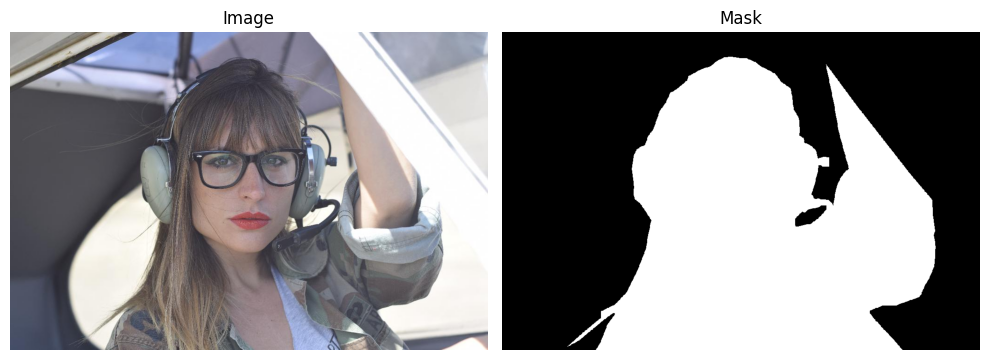

In [25]:
test_data = SegmentationDataset(dataset)

img = test_data[23]

print(f"Image shape: {img[0].shape}")
print(f"Mask shape: {img[1].shape}")

print(f"Image dtype: {img[0].dtype}")
print(f"Mask dtype: {img[1].dtype}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0])
ax[0].set_title("Image")
ax[0].set_axis_off()

ax[1].imshow(img[1], cmap="gray")
ax[1].set_title("Mask")
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

# Traing Pipeline

In [20]:
def traning_fn(loader, model, optimizer, loss_fn, scaler):
  model.train()
  loop = tqdm(loader)
  running_loss = 0.0

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # Forward pass
    with torch.amp.autocast(device_type=DEVICE):
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # Backward pass
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update tqdm loop
    running_loss += loss.item()
    loop.set_postfix(loss=loss.item())

  return running_loss / len(loader)

In [21]:
def main():
  train_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  # model = UNet(in_channels=3, out_channels=1).to(DEVICE)
  model = ResNetUNet(out_channels=1, encoder_name="resnet34", pretrained=True).to(DEVICE)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Load Dataset
  train_dataset = SegmentationDataset(train_paths, transform=train_transform)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=TRAIN_DATA_SHUFFLE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  val_dataset = SegmentationDataset(val_paths, transform=val_transform)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  # test_dataset = SegmentationDataset(test_paths, transform=val_transform)
  # test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  print(f"Train batch size: {len(train_dataloader)}")
  print(f"Val batch size: {len(val_dataloader)}")
  print(f"Test batch size: {len(test_dataloader)}\n")

  # Load model
  if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

  # Requred Variable
  scaler = torch.amp.GradScaler(device=DEVICE)

  # early_stopping = EarlyStopping(tolerance=4, min_delta=10)
  early_stopping = EarlyStopping(patience=4, delta=1e-3)

  train_loss_list = []
  validation_loss_list = []

  # Traning Loop
  for epoch in range(NUM_EPOCHS):
    # Train Model
    train_loss = traning_fn(train_dataloader, model, optimizer, loss_fn, scaler)

    print()
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
    print(f"Train loss: {train_loss}")

    # Save Model
    if SAVE_MODEL and epoch % 2 == 0:
      checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
      }
      save_checkpoint(checkpoint, CHECKPOINT)

    # Check Accuracy
    if CHECK_ACCURACY:
      check_accuracy(val_dataloader, model, device=DEVICE)

    # Save some output Images
    save_predictions_as_imgs(val_dataloader, model, folder="saved_images/", device=DEVICE)

    # early stopping
    # early_stopping(train_loss, validation_loss)
    # if early_stopping.early_stop:
    #   print("We are at epoch:", epoch)
    #   break

    # Update traing and validation loss
    train_loss_list.append(train_loss)

    # Check Validation
    if CHECK_VALIDATION_LOSS:
      validation_loss = val_loss(val_dataloader, model, loss_fn, device=DEVICE)
      print(f"Validation loss: {validation_loss}")
      early_stopping(validation_loss, model)
      validation_loss_list.append(validation_loss)

      if early_stopping.early_stop:
          print("Early stopping")
          break
      else:
        print(f"patience: {early_stopping.counter} out of {early_stopping.patience}")

  # early_stopping.load_best_model(model)

  return model, train_loss_list, validation_loss_list

In [ ]:
history = main()

In [ ]:
# !rm -r "/content/saved_images"

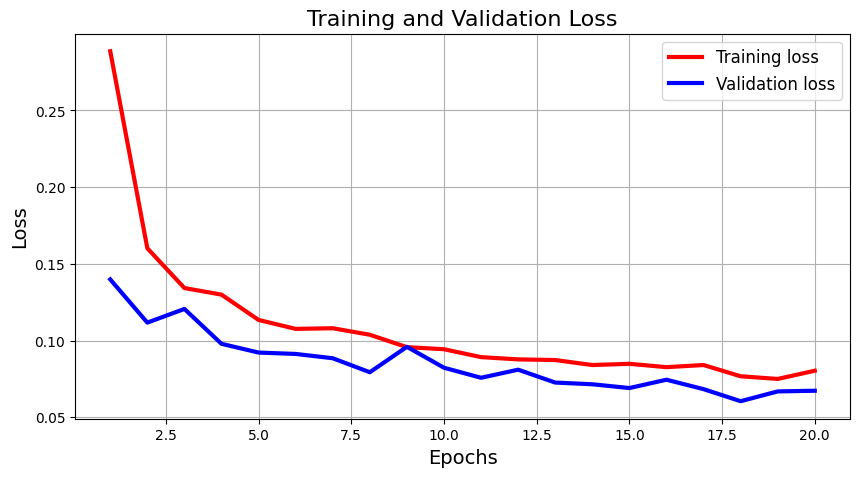

In [32]:
model, train_losses, val_losses = history
epochs = range(1, len(train_losses) + 1)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training loss', color='r', linewidth=3.0)
plt.plot(epochs, val_losses, label='Validation loss', color='b', linewidth=3.0)

# Adding titles and labels
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.show()

🚀 Loading checkpoint


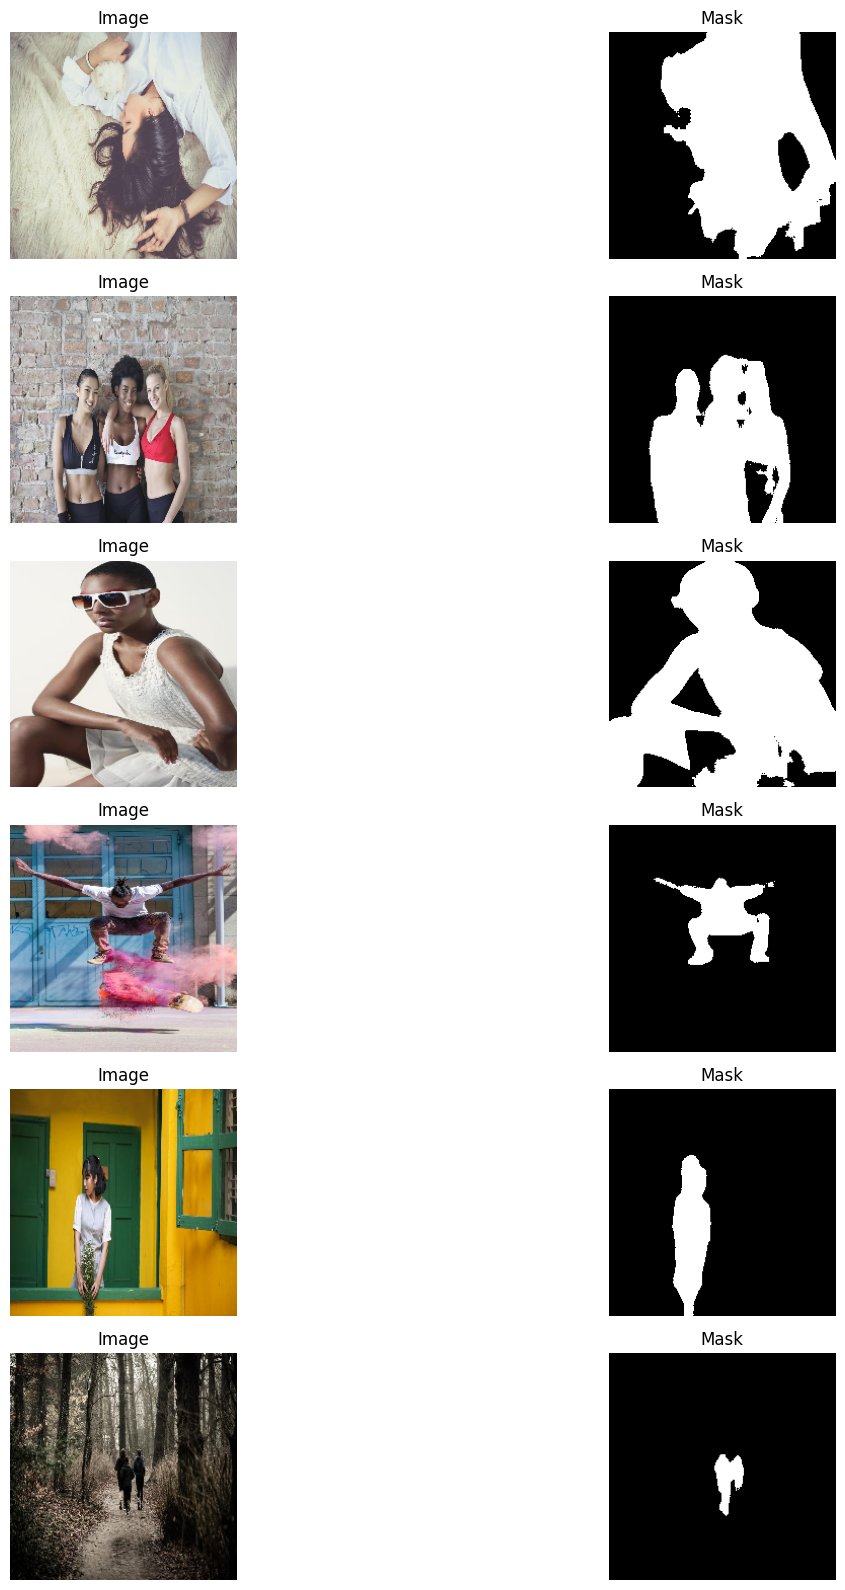

In [45]:
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

test_transform = A.Compose(
    [
      A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
      A.Normalize(
          mean=[0.0, 0.0, 0.0],
          std=[1.0, 1.0, 1.0],
          max_pixel_value=255.0,
      ),
      ToTensorV2(),
    ],
)

test_dataset = SegmentationDataset(test_paths, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# save_predictions_as_imgs(test_dataloader, model, "test_image", DEVICE)

model.eval()
fig, ax = plt.subplots(6, 2, figsize=(16, 16))

with torch.no_grad():
  for batch_idx, (data, targets) in enumerate(test_dataloader):
    if batch_idx >= 6: # Process only the first 5 batches
      break

    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    predictions = model(data)
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > 0.5).float()

    ax[batch_idx, 0].imshow(data[0].permute(1, 2, 0).cpu().numpy())
    ax[batch_idx, 0].set_title("Image")
    ax[batch_idx, 0].set_axis_off()

    ax[batch_idx, 1].imshow(predictions[0].cpu().numpy().squeeze(), cmap="gray")
    ax[batch_idx, 1].set_title("Mask")
    ax[batch_idx, 1].set_axis_off()

  plt.tight_layout()
  plt.show()